In [72]:
import pandas as pd
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MultiLabelBinarizer, Normalizer, RobustScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import *

import nbimporter
import correlation_matrix_kmeans_functions
import math
from sklearn.feature_extraction import DictVectorizer

In [73]:
data = pd.read_csv('C:/Users/eleni.tziaferi/Desktop/grocery_data/order_products__train.csv')
orders = pd.read_csv('C:/Users/eleni.tziaferi/Desktop/grocery_data/orders.csv')

In [74]:
orders.head(5)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [75]:
data.head(5)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [76]:
df = pd.merge(orders, data, how='left', on='order_id')
df = df.groupby(['user_id', 'order_id']).agg({'eval_set':'first', 'order_number':'max', 'order_dow':'max',
                                              'order_hour_of_day':'mean', 'days_since_prior_order':'mean', 
                                              'product_id':'count','add_to_cart_order':'count',  'reordered':'sum' }).fillna(0)

In [107]:
grouped = (df.reset_index()).groupby(['user_id']).agg({'order_id':'count', 'order_number':'max', 'order_dow':'max',
                                                            'order_hour_of_day':'mean', 'days_since_prior_order':'mean',
                                                            'product_id':'sum', 'add_to_cart_order':'sum',  'reordered':'mean'}).reset_index()

In [109]:
group_by_user = grouped.drop(['user_id'], axis=1, errors='ignore')

### Correlation Matrix

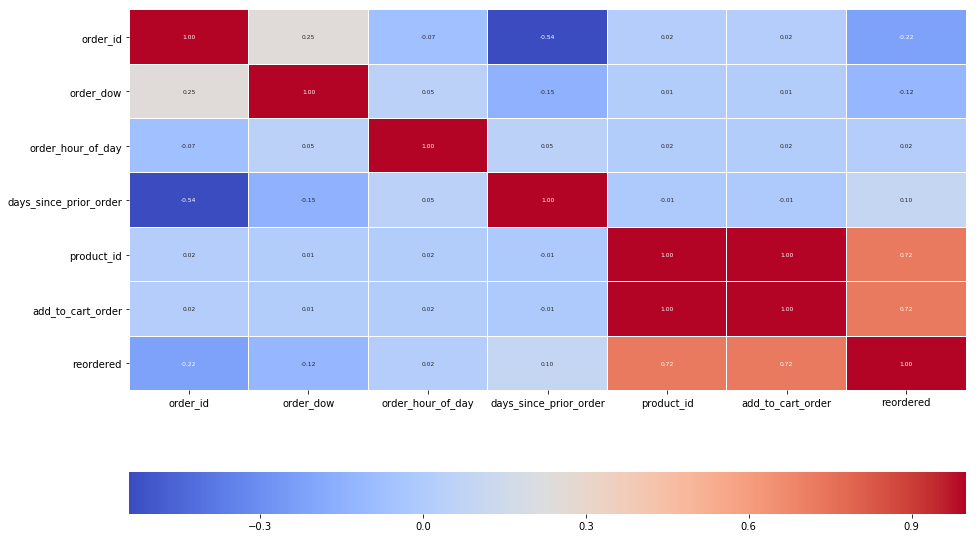

In [91]:
correlation_matrix = correlation_matrix_kmeans_functions.correlation_matrix()
correlation_plot = correlation_matrix.plot_correlation_heatmap(group_by_user)

### PCA

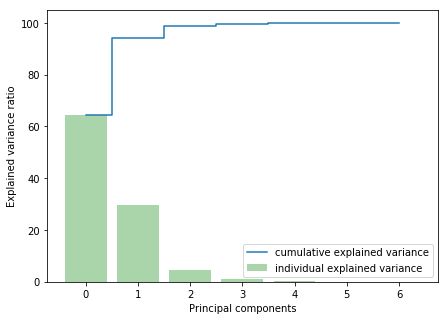

C:\Users\eleni.tziaferi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\eleni.tziaferi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [92]:
pca = correlation_matrix_kmeans_functions.pca(group_by_user, 0.8, True)
pca_analysis_plot = pca.pca_analysis()

### Sihlouette

NameError: name 'clustering_algorithm' is not defined

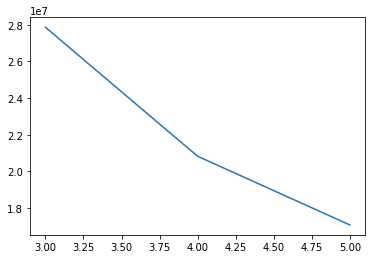

In [93]:
sihlouette = correlation_matrix_kmeans_functions.elbow_method_for_optimum_num_of_clusters()
sihlouette.elbow_method(3, 6, group_by_user.iloc[:, :5])

In [95]:
group_by_user[:12000].shape

(12000, 7)

In [94]:
kmeans_list_metrics = []

for num_of_clusters in range(3, 15):

    kmeans = KMeans(n_clusters= int(num_of_clusters), init='k-means++', n_init=10,  random_state=42, verbose=0)
    predictions = kmeans.fit_predict(group_by_user[:12000])
    centers = kmeans.cluster_centers_
    wcss = kmeans.inertia_
    num_jobs = kmeans.n_iter_
    silhouette = silhouette_score(group_by_user[:12000], predictions, 'euclidean')

    kmeans_list_metrics.append({'clusters': num_of_clusters, 'silhouette': silhouette,
                                'error': wcss, 'num_jobs': num_jobs})

    print("For n_clusters = {}, silhouette score is {}, cluster_errors is {}, "
          "n_jobs {})".format(num_of_clusters, silhouette, wcss, num_jobs))

For n_clusters = 3, silhouette score is 0.41250128386528473, cluster_errors is 2053492.1702537131, n_jobs 12)
For n_clusters = 4, silhouette score is 0.4210528070679053, cluster_errors is 1546041.2726320329, n_jobs 9)
For n_clusters = 5, silhouette score is 0.33995014982305294, cluster_errors is 1311899.21831683, n_jobs 24)
For n_clusters = 6, silhouette score is 0.33806835830816584, cluster_errors is 1105163.0060181525, n_jobs 31)
For n_clusters = 7, silhouette score is 0.33949122986692654, cluster_errors is 994009.0838860282, n_jobs 20)
For n_clusters = 8, silhouette score is 0.29564701904713986, cluster_errors is 888762.714438494, n_jobs 21)
For n_clusters = 9, silhouette score is 0.29635685738131207, cluster_errors is 806499.2344371518, n_jobs 26)
For n_clusters = 10, silhouette score is 0.2864789180256793, cluster_errors is 741057.4378162037, n_jobs 46)
For n_clusters = 11, silhouette score is 0.2949627268187664, cluster_errors is 679389.2993439586, n_jobs 40)
For n_clusters = 12,

In [96]:
scores = pd.DataFrame(kmeans_list_metrics)
scores = scores[(scores['silhouette'] == scores['silhouette'].max())]

In [97]:
scores

,clusters,error,num_jobs,silhouette
1,4,1.546041e+06,9,0.421053


In [98]:
scores.clusters.values[0]

4

In [99]:
kmeans = KMeans(n_clusters=int(scores.clusters.values[0]), init='k-means++', random_state=42, verbose=0)
kmeans.fit_predict(group_by_user[:12000])
clusters_labels = kmeans.labels_
clusters_centers = kmeans.cluster_centers_


In [100]:
clusters_labels

array([1, 2, 1, ..., 0, 2, 1])

In [101]:
subset = group_by_user[:12000]

In [111]:
subset['labels'] = clusters_labels
subset['users_id'] = (grouped['user_id'])[:12000]

C:\Users\eleni.tziaferi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\eleni.tziaferi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


['blue', 'purple', 'blue', 'blue', 'blue', 'blue', 'orange', 'purple', 'purple', 'blue']


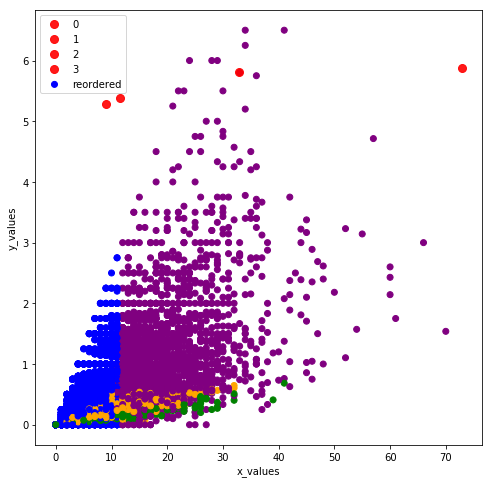

In [133]:
fig = plt.figure(figsize=(8,8))
colors = ['orange','blue','purple','green']
colored = [colors[k] for k in subset['labels']]
print (colored[0:10])
plt.scatter(subset.iloc[:,5],subset.iloc[:,6],  color = colored)
for ci,c in enumerate(clusters_centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()